# Multi-Armed Bandit Exploration

This notebook demonstrates an epsilon-greedy multi-armed bandit (MAB) for ad slot bidding. We simulate ad slots with fixed click-through rates (CTRs) and use the MAB to maximize clicks by balancing exploration and exploitation.

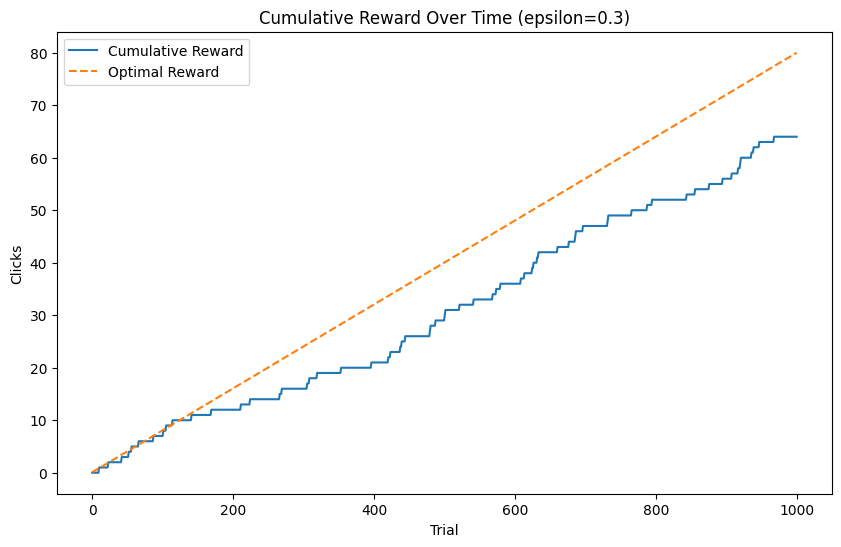

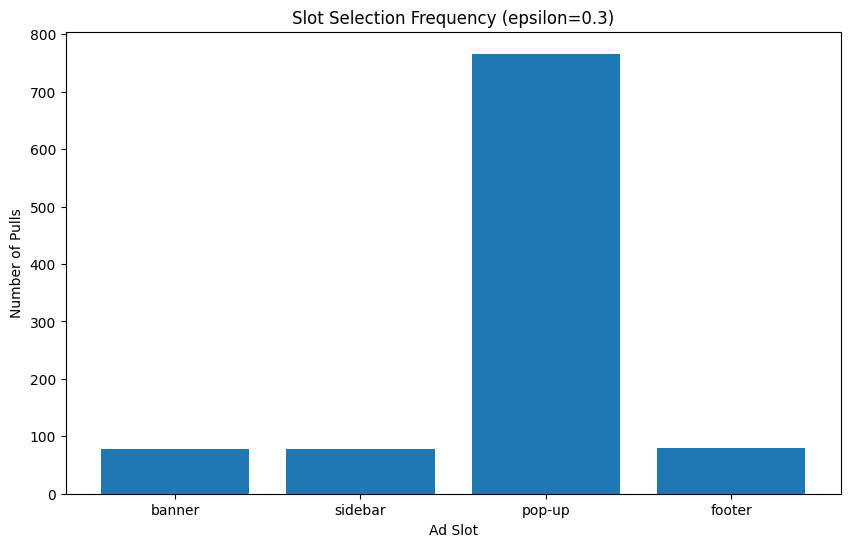

Total clicks: 64
Slot choices (first 10): [2, 3, 3, 1, 0, 0, 2, 1, 0, 3]
Final average rewards per slot:
  banner: 0.0641 (True CTR: 0.05, Pulls: 78.0, Clicks: 5)
  sidebar: 0.0130 (True CTR: 0.02, Pulls: 77.0, Clicks: 1)
  pop-up: 0.0731 (True CTR: 0.08, Pulls: 766.0, Clicks: 56)
  footer: 0.0253 (True CTR: 0.03, Pulls: 79.0, Clicks: 2)
Cumulative reward (last 5): [64 64 64 64 64]
Regret (last 5): [15.68 15.76 15.84 15.92 16.  ]


In [1]:
import sys
import os
# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt
from src.data_generator import generate_ad_slots, simulate_click
from src.mab_algorithm import EpsilonGreedyMAB

def run_simulation(n_trials=1000, epsilon=0.3, seed=40):
    ad_slots = generate_ad_slots()
    ctrs = list(ad_slots.values())
    mab = EpsilonGreedyMAB(n_slots=len(ctrs), epsilon=epsilon)
    rewards = []
    choices = []
    slot_rewards = [0] * len(ctrs)
    rng_select = np.random.RandomState(seed)
    rng_reward = np.random.RandomState(seed)

    for t in range(n_trials):
        slot = mab.select_slot(rng=rng_select)
        reward = simulate_click(ctrs[slot], rng=rng_reward)
        mab.update(slot, reward)
        rewards.append(reward)
        choices.append(int(slot))
        slot_rewards[slot] += reward

    return rewards, choices, ad_slots, mab, slot_rewards

# Run simulation with epsilon=0.3
rewards, choices, ad_slots, mab, slot_rewards = run_simulation(epsilon=0.3)
slot_names = list(ad_slots.keys())
ctrs = list(ad_slots.values())

# Analyze results
cumulative_reward = np.cumsum(rewards)
optimal_reward = max(ctrs) * np.arange(1, 1001)
regret = optimal_reward - cumulative_reward

# Plot cumulative reward
plt.figure(figsize=(10, 6))
plt.plot(cumulative_reward, label="Cumulative Reward")
plt.plot(optimal_reward, label="Optimal Reward", linestyle="--")
plt.xlabel("Trial")
plt.ylabel("Clicks")
plt.title("Cumulative Reward Over Time (epsilon=0.3)")
plt.legend()
plt.show()

# Plot slot choices
plt.figure(figsize=(10, 6))
slot_counts = [sum(1 for choice in choices if choice == i) for i in range(len(slot_names))]
plt.bar(range(len(slot_names)), slot_counts, width=0.8, align="center")
plt.xticks(ticks=range(len(slot_names)), labels=slot_names)
plt.xlabel("Ad Slot")
plt.ylabel("Number of Pulls")
plt.title("Slot Selection Frequency (epsilon=0.3)")
plt.show()

# Print results
print("Total clicks:", sum(rewards))
print("Slot choices (first 10):", choices[:10])
print("Final average rewards per slot:")
for i, (name, reward, count, tot_reward) in enumerate(zip(slot_names, mab.values, mab.counts, slot_rewards)):
    print(f"  {name}: {reward:.4f} (True CTR: {ad_slots[name]}, Pulls: {count}, Clicks: {tot_reward})")
print("Cumulative reward (last 5):", cumulative_reward[-5:])
print("Regret (last 5):", regret[-5:])